In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

BASE_DIR = "/content/drive/MyDrive/SkinAI_Project"
PROCESSED_DIR = os.path.join(BASE_DIR, "data", "processed")
MODELS_DIR = os.path.join(BASE_DIR, "models")

REPORTS_DIR = os.path.join(BASE_DIR, "reports")
FIG_DIR = os.path.join(REPORTS_DIR, "figures")
METRICS_DIR = os.path.join(REPORTS_DIR, "metrics")

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

print("BASE_DIR :", BASE_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)
print("MODELS_DIR :", MODELS_DIR)
print("Processed files:", os.listdir(PROCESSED_DIR))


Mounted at /content/drive
BASE_DIR : /content/drive/MyDrive/SkinAI_Project
PROCESSED_DIR: /content/drive/MyDrive/SkinAI_Project/data/processed
MODELS_DIR : /content/drive/MyDrive/SkinAI_Project/models
Processed files: ['text_augmented.csv', 'test_predictions.csv', 'structured', 'disease', 'unlabeled_text.csv', 'text_merged.csv', 'text_cleaned.csv', 'val.csv', 'text_cleaned_grouped6.csv', 'train.csv', 'text_cleaned_normalized.csv', 'dataset_health_report.csv', 'test.csv']


In [2]:
import pandas as pd

train_path = os.path.join(PROCESSED_DIR, "train.csv")
val_path   = os.path.join(PROCESSED_DIR, "val.csv")
test_path  = os.path.join(PROCESSED_DIR, "test.csv")

df_train = pd.read_csv(train_path)
df_val   = pd.read_csv(val_path)
df_test  = pd.read_csv(test_path)

print("Train shape:", df_train.shape)
print("Val shape  :", df_val.shape)
print("Test shape :", df_test.shape)
print("Columns:", df_train.columns.tolist())

display(df_train.head())
print("\nLabel distribution (train top 30):")
print(df_train["label"].value_counts().head(30))

X_train = df_train["text"].astype(str).tolist()
y_train = df_train["label"].astype(str).tolist()

X_val = df_val["text"].astype(str).tolist()
y_val = df_val["label"].astype(str).tolist()

X_test = df_test["text"].astype(str).tolist()
y_test = df_test["label"].astype(str).tolist()

print("\nClasses:", df_train["label"].nunique())


Train shape: (7433, 3)
Val shape  : (1593, 3)
Test shape : (1593, 3)
Columns: ['text', 'label', 'source']


,text,label,source
0,"age: 68 | gender: male | symptom text: lately,...",Contact dermatitis (Irritant),synthetic/clinical_cases_10000.csv
1,age: 56 | gender: male | symptom text: recentl...,Tinea cruris (Jock itch),synthetic/clinical_cases_10000.csv
2,age: 48 | gender: male | symptom text: these d...,Cellulitis,synthetic/clinical_cases_10000.csv
3,age: 35 | gender: male | symptom text: i've no...,Seborrheic dermatitis,synthetic/clinical_cases_10000.csv
4,age: 48 | gender: female | symptom text: recen...,Impetigo,synthetic/clinical_cases_10000.csv



Label distribution (train top 30):
label
Tinea corporis (Ringworm)         275
Urticaria (Hives)                 269
Impetigo                          268
Seborrheic dermatitis             264
Dyshidrotic eczema                257
Herpes simplex (Cold sores)       253
Rosacea                           253
Pityriasis versicolor             252
Lichen planus                     248
Folliculitis                      248
Acne vulgaris                     248
Tinea capitis (Scalp ringworm)    246
Contact dermatitis (Irritant)     246
Perioral dermatitis               246
Tinea cruris (Jock itch)          245
Molluscum contagiosum             245
Chronic urticaria                 244
Vitiligo                          243
Nummular eczema                   242
Scabies                           239
Acne rosacea                      236
Cellulitis                        234
Psoriasis vulgaris                234
Contact dermatitis (Allergic)     231
Herpes zoster (Shingles)          230
Atopic d

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    min_df=2,
    max_df=0.9
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)

print("TF-IDF shapes:")
print(" Train:", X_train_tfidf.shape)
print(" Val  :", X_val_tfidf.shape)
print(" Test :", X_test_tfidf.shape)


TF-IDF shapes:
 Train: (7433, 4572)
 Val  : (1593, 4572)
 Test : (1593, 4572)


In [4]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.utils.class_weight import compute_class_weight

# Classes must be fixed across partial_fit calls
classes = np.unique(y_train)

# ✅ SGD model WITHOUT class_weight="balanced" (not supported in partial_fit)
sgd = SGDClassifier(
    loss="log_loss",
    max_iter=1,          # not used in partial_fit loop, but keep valid
    tol=None,            # important: disable early stopping for partial_fit epochs
    random_state=42,
    learning_rate="optimal"
)

# ✅ Compute class weights manually (balanced) and convert to sample weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=np.array(y_train)
)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}

# sample_weight for each training example
sample_weight_train = np.array([class_weight_dict[label] for label in y_train], dtype=float)

print("Computed class weights (balanced):")
for c in classes[:10]:
    print(f"  {c}: {class_weight_dict[c]:.4f}")
print("... (showing first 10)")

train_losses = []
val_losses = []

EPOCHS = 25

for epoch in range(1, EPOCHS + 1):
    # partial_fit supports sample_weight
    if epoch == 1:
        sgd.partial_fit(X_train_tfidf, y_train, classes=classes, sample_weight=sample_weight_train)
    else:
        sgd.partial_fit(X_train_tfidf, y_train, sample_weight=sample_weight_train)

    # Compute log loss using probabilities
    train_probs = sgd.predict_proba(X_train_tfidf)
    val_probs   = sgd.predict_proba(X_val_tfidf)

    tr_loss = log_loss(y_train, train_probs, labels=classes)
    va_loss = log_loss(y_val, val_probs, labels=classes)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)

    print(f"Epoch {epoch:02d} | Train LogLoss: {tr_loss:.4f} | Val LogLoss: {va_loss:.4f}")

print("\nTraining finished (SGD partial_fit + balanced sample weights).")


Computed class weights (balanced):
  Acne: 7.5309
  Acne rosacea: 0.6701
  Acne vulgaris: 0.6377
  Actinic keratosis: 6.3260
  Athlete Foot (Tinea Pedis): 19.7686
  Athlete's Foot (Tinea Pedis): 19.7686
  Atopic Dermatitis: 6.3260
  Atopic dermatitis (Eczema): 0.6936
  Benign keratosis: 5.6482
  Cellulitis: 0.6759
... (showing first 10)
Epoch 01 | Train LogLoss: 0.8857 | Val LogLoss: 0.9934
Epoch 02 | Train LogLoss: 0.8564 | Val LogLoss: 0.9718
Epoch 03 | Train LogLoss: 0.8498 | Val LogLoss: 0.9660
Epoch 04 | Train LogLoss: 0.8462 | Val LogLoss: 0.9625
Epoch 05 | Train LogLoss: 0.8438 | Val LogLoss: 0.9601
Epoch 06 | Train LogLoss: 0.8418 | Val LogLoss: 0.9582
Epoch 07 | Train LogLoss: 0.8403 | Val LogLoss: 0.9566
Epoch 08 | Train LogLoss: 0.8389 | Val LogLoss: 0.9553
Epoch 09 | Train LogLoss: 0.8378 | Val LogLoss: 0.9542
Epoch 10 | Train LogLoss: 0.8368 | Val LogLoss: 0.9533
Epoch 11 | Train LogLoss: 0.8359 | Val LogLoss: 0.9524
Epoch 12 | Train LogLoss: 0.8352 | Val LogLoss: 0.9517
E

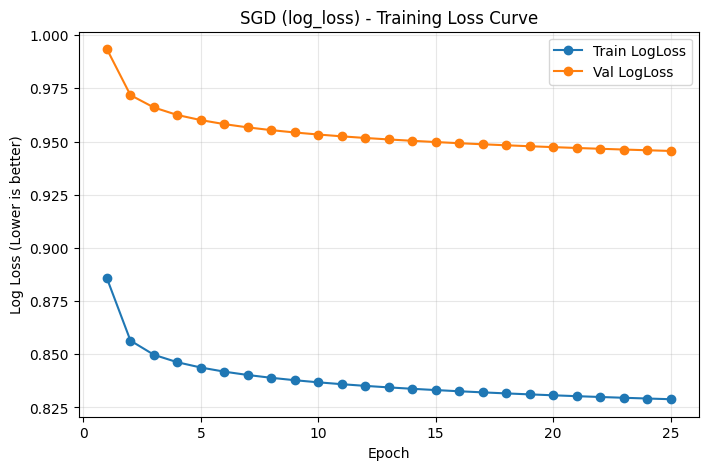

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/sgd_logloss_loss_curve.png


In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, marker="o", label="Train LogLoss")
plt.plot(range(1, len(val_losses)+1), val_losses, marker="o", label="Val LogLoss")
plt.title("SGD (log_loss) - Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Log Loss (Lower is better)")
plt.grid(True, alpha=0.3)
plt.legend()

out_path = os.path.join(FIG_DIR, "sgd_logloss_loss_curve.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


In [6]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

def evaluate_split(name, model, X, y_true):
    y_pred = model.predict(X)
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"\n=== {name} ===")
    print("Accuracy:", round(acc, 4))
    print("Macro-F1:", round(f1m, 4))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    return y_pred, acc, f1m

y_pred_train, acc_train, f1_train = evaluate_split("TRAIN", sgd, X_train_tfidf, y_train)
y_pred_val,   acc_val,   f1_val   = evaluate_split("VALIDATION", sgd, X_val_tfidf, y_val)
y_pred_test,  acc_test,  f1_test  = evaluate_split("TEST", sgd, X_test_tfidf, y_test)

report_path = os.path.join(METRICS_DIR, "sgd_logloss_report.txt")
with open(report_path, "w", encoding="utf-8") as f:
    f.write(classification_report(y_test, y_pred_test, zero_division=0))
print("Saved report:", report_path)



=== TRAIN ===
Accuracy: 0.7999
Macro-F1: 0.853

Classification report:
                                precision    recall  f1-score   support

                          Acne       0.78      1.00      0.88        21
                  Acne rosacea       1.00      1.00      1.00       236
                 Acne vulgaris       1.00      0.99      1.00       248
             Actinic keratosis       1.00      1.00      1.00        25
    Athlete Foot (Tinea Pedis)       1.00      1.00      1.00         8
  Athlete's Foot (Tinea Pedis)       1.00      1.00      1.00         8
             Atopic Dermatitis       0.93      1.00      0.96        25
    Atopic dermatitis (Eczema)       0.30      0.33      0.32       228
              Benign keratosis       0.88      1.00      0.93        28
                    Cellulitis       1.00      1.00      1.00       234
             Chronic urticaria       1.00      1.00      1.00       244
            Contact Dermatitis       1.00      1.00      1.00  

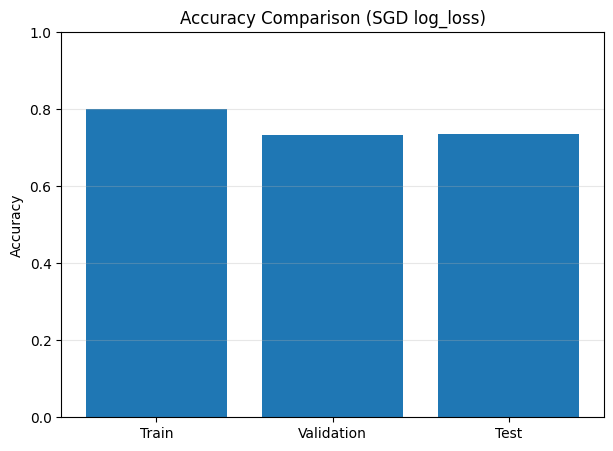

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/sgd_logloss_accuracy_bar.png


In [7]:
plt.figure(figsize=(7,5))
plt.bar(["Train", "Validation", "Test"], [acc_train, acc_val, acc_test])
plt.title("Accuracy Comparison (SGD log_loss)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis="y", alpha=0.3)

out_path = os.path.join(FIG_DIR, "sgd_logloss_accuracy_bar.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


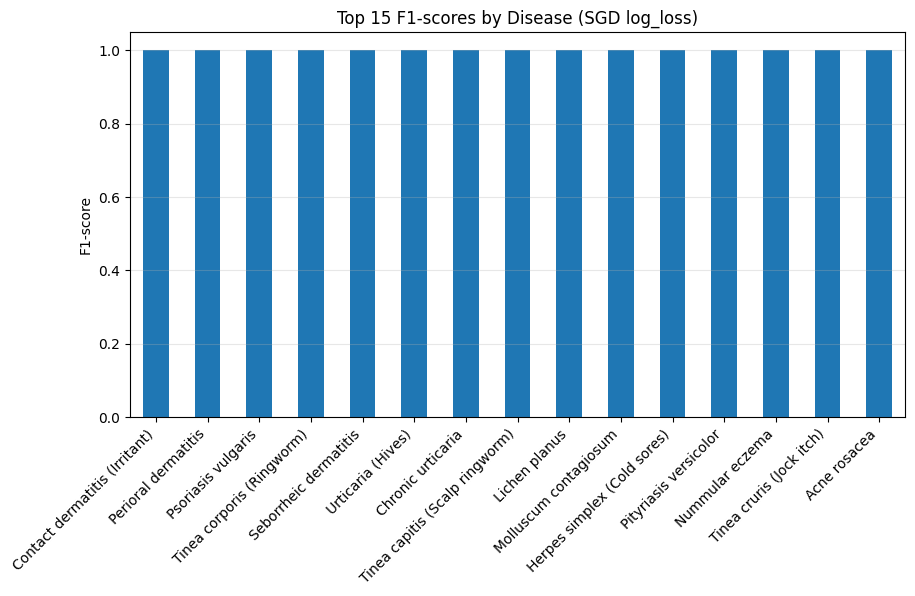

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/sgd_logloss_top15_f1.png


In [8]:
from sklearn.metrics import f1_score
import pandas as pd

unique_labels = df_test["label"].unique()
f1_scores = {label: f1_score(y_test, y_pred_test, labels=[label], average="macro") for label in unique_labels}

pd.Series(f1_scores).sort_values(ascending=False).head(15).plot(kind="bar", figsize=(10,5))
plt.title("Top 15 F1-scores by Disease (SGD log_loss)")
plt.ylabel("F1-score")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)

out_path = os.path.join(FIG_DIR, "sgd_logloss_top15_f1.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


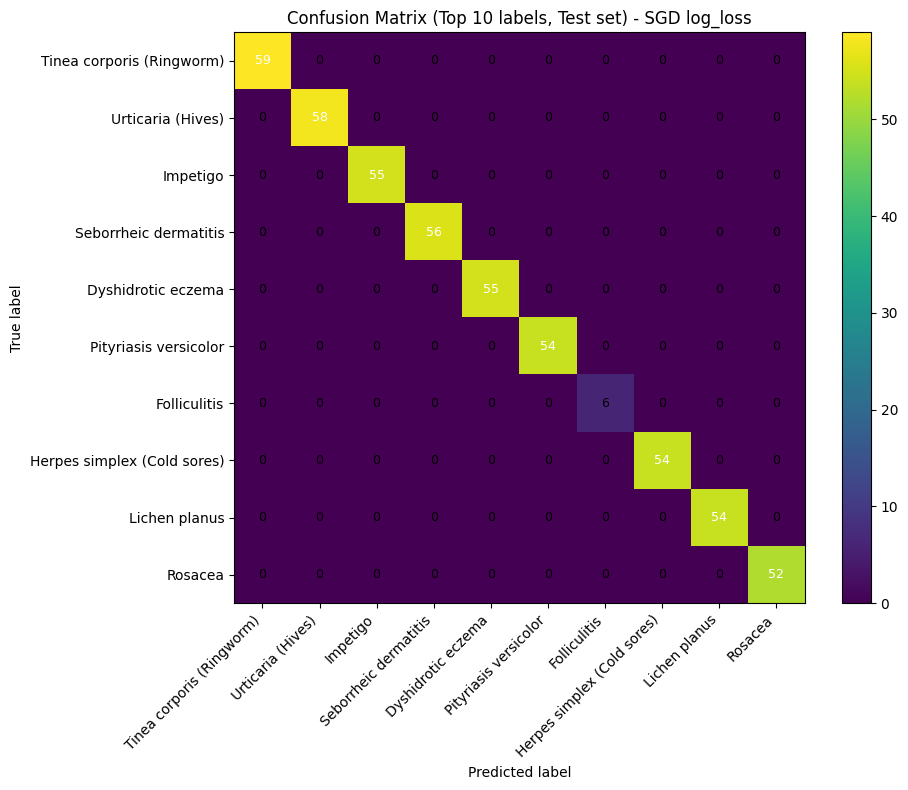

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/sgd_logloss_confusion_top10.png


In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix

N = 10
top_labels = pd.Series(y_test).value_counts().head(N).index.tolist()

mask = [y in top_labels for y in y_test]
y_true_top = np.array(y_test)[mask]
y_pred_top = np.array(y_pred_test)[mask]

cm = confusion_matrix(y_true_top, y_pred_top, labels=top_labels)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(len(top_labels)),
    yticks=np.arange(len(top_labels)),
    xticklabels=top_labels,
    yticklabels=top_labels,
    ylabel="True label",
    xlabel="Predicted label",
    title=f"Confusion Matrix (Top {N} labels, Test set) - SGD log_loss"
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

thresh = cm.max() / 2. if cm.max() > 0 else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm[i, j]
        ax.text(j, i, str(val), ha="center", va="center",
                color="white" if val > thresh else "black", fontsize=9)

plt.tight_layout()

out_path = os.path.join(FIG_DIR, "sgd_logloss_confusion_top10.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


TEST Log Loss: 0.9595
TEST Brier Score: 0.3287


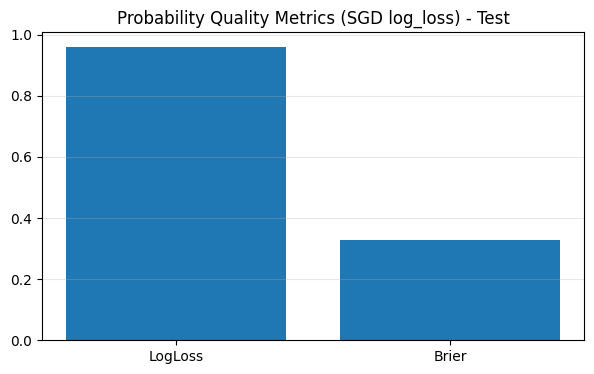

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/sgd_logloss_prob_quality.png


In [10]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import label_binarize

test_probs = sgd.predict_proba(X_test_tfidf)

test_logloss = log_loss(y_test, test_probs, labels=classes)
print("TEST Log Loss:", round(test_logloss, 4))

y_test_bin = label_binarize(y_test, classes=classes)
brier = np.mean(np.sum((y_test_bin - test_probs)**2, axis=1))
print("TEST Brier Score:", round(float(brier), 4))

# Plot
plt.figure(figsize=(7,4))
plt.bar(["LogLoss", "Brier"], [test_logloss, brier])
plt.title("Probability Quality Metrics (SGD log_loss) - Test")
plt.grid(True, axis="y", alpha=0.3)

out_path = os.path.join(FIG_DIR, "sgd_logloss_prob_quality.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


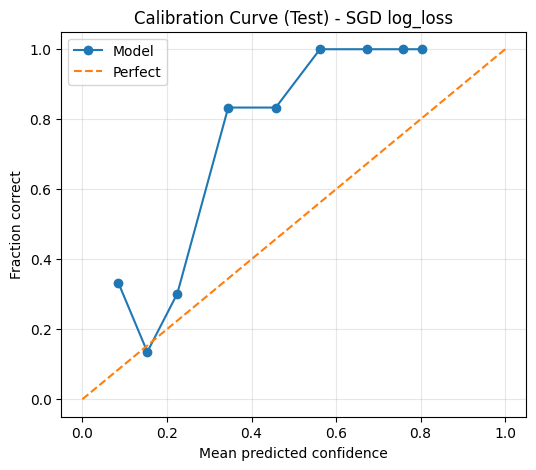

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/sgd_logloss_calibration_curve.png


In [11]:
from sklearn.calibration import calibration_curve

conf_test = test_probs.max(axis=1)
correct_test = (np.array(y_pred_test) == np.array(y_test)).astype(int)

frac_pos, mean_pred = calibration_curve(correct_test, conf_test, n_bins=10, strategy="uniform")

plt.figure(figsize=(6,5))
plt.plot(mean_pred, frac_pos, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect")
plt.title("Calibration Curve (Test) - SGD log_loss")
plt.xlabel("Mean predicted confidence")
plt.ylabel("Fraction correct")
plt.grid(True, alpha=0.3)
plt.legend()

out_path = os.path.join(FIG_DIR, "sgd_logloss_calibration_curve.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


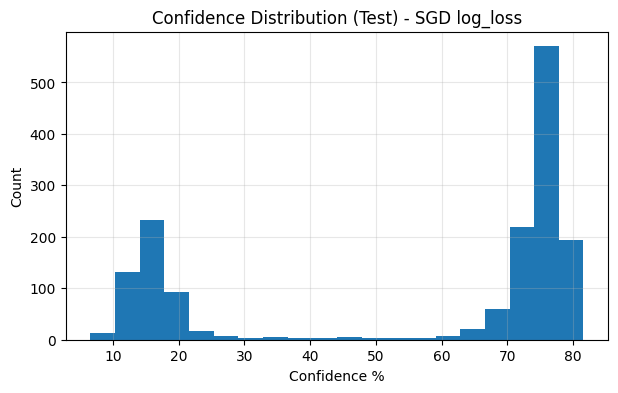

Saved: /content/drive/MyDrive/SkinAI_Project/reports/figures/sgd_logloss_confidence_hist.png


In [12]:
plt.figure(figsize=(7,4))
plt.hist(conf_test * 100, bins=20)
plt.title("Confidence Distribution (Test) - SGD log_loss")
plt.xlabel("Confidence %")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)

out_path = os.path.join(FIG_DIR, "sgd_logloss_confidence_hist.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


In [13]:
import joblib

MODEL_PATH = os.path.join(MODELS_DIR, "skin_text_classifier_tfidf_sgd_logloss.joblib")
VECT_PATH  = os.path.join(MODELS_DIR, "vectorizer_tfidf.joblib")

joblib.dump(sgd, MODEL_PATH)
joblib.dump(vectorizer, VECT_PATH)

print("Saved classifier to:", MODEL_PATH)
print("Saved vectorizer to :", VECT_PATH)


Saved classifier to: /content/drive/MyDrive/SkinAI_Project/models/skin_text_classifier_tfidf_sgd_logloss.joblib
Saved vectorizer to : /content/drive/MyDrive/SkinAI_Project/models/vectorizer_tfidf.joblib


In [14]:
def predict_with_confidence(model, vectorizer, text: str):
    """
    Predict label + confidence for SGD (log_loss).
    confidence = predicted class probability (0..1) if predict_proba exists.
    """
    X = vectorizer.transform([text])
    pred = model.predict(X)[0]

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)[0]
        classes = list(model.classes_)
        conf = float(proba[classes.index(pred)])
        return pred, conf

    return pred, None

samples = [
    "I have pimples and red bumps with white pus on my cheeks and forehead.",
    "My skin is very dry and itchy with red patches that crack sometimes.",
    "I have a circular itchy rash with raised red border and clear center."
]

for s in samples:
    p, c = predict_with_confidence(sgd, vectorizer, s)  # ✅ use sgd here
    print("\nTEXT:", s)
    print("PRED:", p)
    print("CONF:", "N/A" if c is None else f"{c*100:.2f}%")



TEXT: I have pimples and red bumps with white pus on my cheeks and forehead.
PRED: Acne vulgaris
CONF: 10.05%

TEXT: My skin is very dry and itchy with red patches that crack sometimes.
PRED: Benign keratosis
CONF: 4.72%

TEXT: I have a circular itchy rash with raised red border and clear center.
PRED: Tinea corporis (Ringworm)
CONF: 11.21%


In [15]:
import numpy as np

def predict_topk(model, vectorizer, text: str, k: int = 3):
    X = vectorizer.transform([text])

    if not hasattr(model, "predict_proba"):
        pred = model.predict(X)[0]
        return [(pred, None)]

    proba = model.predict_proba(X)[0]
    classes = np.array(model.classes_)
    top_idx = np.argsort(proba)[::-1][:k]

    return [(classes[i], float(proba[i])) for i in top_idx]

for s in samples:
    top3 = predict_topk(sgd, vectorizer, s, k=3)
    print("\nTEXT:", s)
    for rank, (lbl, conf) in enumerate(top3, 1):
        print(f"Top-{rank}: {lbl} | {conf*100:.2f}%")



TEXT: I have pimples and red bumps with white pus on my cheeks and forehead.
Top-1: Acne vulgaris | 10.05%
Top-2: Acne rosacea | 9.52%
Top-3: Folliculitis | 5.31%

TEXT: My skin is very dry and itchy with red patches that crack sometimes.
Top-1: Benign keratosis | 4.72%
Top-2: Atopic Dermatitis | 4.71%
Top-3: Psoriasis | 4.05%

TEXT: I have a circular itchy rash with raised red border and clear center.
Top-1: Tinea corporis (Ringworm) | 11.21%
Top-2: Tinea Ringworm Candidiasis | 5.35%
Top-3: Ringworm (Tinea Corporis) | 4.57%
